In [27]:
import warnings
warnings.simplefilter('ignore')

# old imports

import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapely.geometry
import shapely.wkt

# correct imports
import os
import ibis
import grpc

from shapely.geometry import MultiPolygon, shape

# testing
from descarteslabs.vektorius.client import Vector
# vector = Vector("platform.stage.descarteslabs.com", 443)
vector = Vector("localhost", 8443)

# real
# from descarteslabs.vektorius import vector

%matplotlib inline

In [3]:
# helper functions

def str_to_dt(s):
    year, month = s.split("_")
    return datetime.datetime(int(year), int(month), 1)

def displacement_helper(dwt, draft, length, width, return_val):
    klass, Cb, Td, disp = displacement.get_displacement(dwt, draft, length, width)
    if return_val == "disp":
        return disp
    elif return_val == "klass":
        return klass

def get_berth_from_point(point_wkt, shape_dict):
    for aoi_name, aoi_poly in shape_dict.items():
        P = shapely.wkt.loads(point_wkt)
        if P.within(aoi_poly):
            return aoi_name
    return np.nan

def get_port_from_berth(s):
    return s.split("_")[0]

/home/joe/code/tutorials/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
VOYAGES_QUERY = """
  SELECT
      mmsi,
      departure,
      arrival,
      origin,
      destination,
      avg_draft,
      avg_speed,
      est_cargo,
  FROM `dl-security-test.dl_ais_derived.${voyages_table}`
  WHERE departure BETWEEN "${start_date}" AND "${end_date}"
  AND ST_WITHIN(origin, ST_GeogFromText("${multi_polygon}"))
  """

VESSELS_QUERY = """
  SELECT
      mmsi,
      length,
      width,
      IFNULL(capacity.dwt, derived_dwt) AS dwt,
      ship_type
  FROM dl-security-test.dl_ais_derived.${vessels_table}
  """

### This notebook will aim to show how voyages data can be used to estimate commodity flows, specifically soybeans out of Brazil. It will demonstrate how to 1) pull voyages originating in areas of interest (Brazilian grain berths), 2) combine with vessel data to estimate cargo, 3) filter by destination, and 4) compare to published statistics

In [51]:
v = vector.table("vessels_v3")
v.filter(v.capacity.dwt.coalesce(v.derived_dwt).isnull()).execute()

/home/joe/code/tutorials/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ais_version,call_sign,class,created_at,flag,general_classification,id,imo,individual_classification,length,...,vessel_and_trading_type,design,dimensions,gross_tonnage,derived_dwt,coefficients,design_draught,lightweight,depth,ship_class
0,0,NULL,B,2017-11-22 01:17:32.272593,CN,Merchant,bca34aed-a266-4102-8e83-3a7bcd8582d7,NaN,Cargo and Passenger,NaN,...,"{'subtype': None, 'trading_category': None, 't...","{'coated': None, 'updated_at': None}","{'air_draught': None, 'draught': None, 'ktm': ...",4980.0,NaN,None,NaN,NaN,NaN,None
1,0,NULL,B,2017-10-04 04:28:32.900077,CN,Service Vessels,f742dfe8-349d-4ba1-8da5-30e230a10d06,NaN,Fast Patrol Ship,NaN,...,"{'subtype': None, 'trading_category': None, 't...","{'coated': None, 'updated_at': None}","{'air_draught': None, 'draught': None, 'ktm': ...",53.0,NaN,None,NaN,NaN,NaN,None
2,0,NULL,B,2017-09-20 04:13:31.113172,US,Pleasure/Leisure,58c5c941-8901-4605-896f-4fe24b8df8d2,NaN,Trawler,NaN,...,"{'subtype': None, 'trading_category': None, 't...","{'coated': None, 'updated_at': None}","{'air_draught': None, 'draught': None, 'ktm': ...",0.0,NaN,None,NaN,NaN,NaN,None
3,0,NULL,B,2017-09-11 01:36:25.997244,CN,Merchant,b4c4db77-5ff7-4bbb-a190-58b893a66b3c,NaN,Cargo and Passenger,NaN,...,"{'subtype': None, 'trading_category': None, 't...","{'coated': None, 'updated_at': None}","{'air_draught': None, 'draught': None, 'ktm': ...",0.0,NaN,None,NaN,NaN,NaN,None
4,0,NULL,B,2017-11-21 14:10:27.924590,CA,Pleasure/Leisure,ee019380-f332-4384-839a-9732dd804805,NaN,Cruiser,NaN,...,"{'subtype': None, 'trading_category': None, 't...","{'coated': None, 'updated_at': None}","{'air_draught': None, 'draught': None, 'ktm': ...",19.0,NaN,None,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380166,0,NULL,A,2017-12-23 04:31:15.295409,CN,Merchant,48271357-c845-42cf-beef-84de6a05f2b9,NaN,Passenger Ship,41.0,...,"{'subtype': None, 'trading_category': None, 't...","{'coated': None, 'updated_at': None}","{'air_draught': None, 'draught': None, 'ktm': ...",5640.0,NaN,None,NaN,NaN,NaN,None
380167,0,TCCH5,A,2019-03-07 09:53:14.523281,TR,Merchant,a5fcb1e4-1472-5b10-8f6f-17a5333ad349,9372171.0,Passenger Ship,NaN,...,"{'subtype': None, 'trading_category': None, 't...","{'coated': None, 'updated_at': None}","{'air_draught': None, 'draught': None, 'ktm': ...",613300.0,NaN,None,NaN,NaN,NaN,None
380168,0,BRZF,A,2017-11-22 01:32:34.696469,CN,Merchant,544906b5-e5a8-4f64-adb3-7d6719608f9f,8881929.0,Passenger Ship,24.0,...,"{'subtype': None, 'trading_category': None, 't...","{'coated': None, 'updated_at': None}","{'air_draught': None, 'draught': None, 'ktm': ...",1820.0,NaN,None,NaN,NaN,NaN,None
380169,0,3YQA,A,2017-11-22 01:53:28.044977,NO,Merchant,ae5c5178-8b0c-410b-b647-c308b223fd4e,9599896.0,Passenger Ship,130.0,...,"{'subtype': 'Ferry', 'trading_category': 'In S...","{'coated': None, 'updated_at': 2019-04-11 13:5...","{'air_draught': None, 'draught': None, 'ktm': ...",7536.0,NaN,None,NaN,NaN,NaN,None


# Construct Vessels Query
We're interested in enriching each voyage with information about the ship making the voyage.  To that end we need to locate the Cargo ships that make voyages, and ensure that we have information about the capacity and dimensions of each ship.

In [31]:
# Constants for queries:
ship_type = "Cargo"
# used for similar-size calculation
length_thresh = 15
width_thresh = 5

# find all cargo ships
vessels_table = vector.table("vessels")
vessels_query = vessels_table[
    vessels_table.mmsi,
    vessels_table.length,
    vessels_table.width,
    vessels_table.ship_type,
    # capacity can be in either or both, prefer capacity.dwt if present
    vessels_table.capacity.dwt.coalesce(vessels_table.derived_dwt).name("dwt")
]
vessels_query = vessels_query.filter((
    vessels_query.ship_type == ship_type) &
    # length and width must be present to estimate displacement
    vessels_query.length.notnull() &
    vessels_query.width.notnull()
)

# some cargo ships don't have a listed capacity (`dwt`), so we
# need to estimate this value using other cargo ships that 
# have similar dimensions AND have a listed capacity.
# we'll use a self join on the vessels table to find these other
# ships and calculate a mean value for each ship missing capacity
similar_vessels_table = vessels_table.view()
similar_vessels = similar_vessels_table[
    similar_vessels_table.length,
    similar_vessels_table.width,
    similar_vessels_table.ship_type,
    # capacity can be in either or both, prefer capacity.dwt if present
    similar_vessels_table.capacity.dwt.coalesce(similar_vessels_table.derived_dwt).name("dwt")
]
# other ships must have dimensions and capacity to be valid for this calculation.
# Making an assumption that similar sized Passenger Ships are not valid comparisons
# for dwt, since they're designed for different "cargo"
similar_vessels = similar_vessels.filter(similar_vessels.dwt.notnull() &
                                         similar_vessels.length.notnull() & 
                                         similar_vessels.width.notnull() &
                                         (similar_vessels.ship_type == ship_type))

# join the target list of vessels to the list of similar vessels
# and exclude target vessels that already have a capacity, we don't
# need to bother estimating their capacity
vessels_missing_dwt = vessels_query.filter(vessels_query.dwt.isnull())
joined = vessels_missing_dwt.cross_join(similar_vessels)
joined = joined[
    vessels_missing_dwt.mmsi,
    vessels_missing_dwt.length,
    vessels_missing_dwt.width,
    vessels_missing_dwt.ship_type,
    similar_vessels.dwt,
    similar_vessels.length.name("similar_length"),
    similar_vessels.width.name("similar_width")
]
joined.filter(
    # length and width of similar ships is +/- some threshhold value
    (joined.similar_length.between(joined.length - length_thresh, joined.length + length_thresh)) &
    (joined.similar_width.between(joined.width - width_thresh, joined.width + width_thresh))
)
    
# calculate mean value of similar ships for each ship with unknown capacity
estimated_dwt_vessels = joined.group_by([
    joined.mmsi,
    joined.length,
    joined.width,
    joined.ship_type,
]).aggregate(dwt=joined.dwt.mean())

# create the final list of vessels with listed and estimated capacity
final_vessels = vessels_query.left_join(estimated_dwt_vessels,
                                        vessels_query.mmsi == estimated_dwt_vessels.mmsi)
final_vessels = final_vessels[
    vessels_query.mmsi,
    vessels_query.length,
    vessels_query.width,
    vessels_query.ship_type,
    vessels_query.dwt.coalesce(estimated_dwt_vessels.dwt).name("dwt"),
    # allows us to determine if the dwt was estimated or listed
    estimated_dwt_vessels.mmsi.isnull().name("estimated")
]
# if there still isn't a listed capcity, then remove those ships
final_vessels = final_vessels.filter(final_vessels.dwt.notnull() &
                                     (final_vessels.dwt != 0))
final_vessels.execute()

KeyboardInterrupt: 

# Construct Voyages Query
Now that we've identified potential cargo ships, we can find the voyages those ships have made.

In [10]:
# load brazilian grain berth shapes and make a multipolygon to query from voyages
workdir = os.getcwd()  # TODO this probably needs to be tweaked a little
fname = os.path.join(workdir, "brazil_grain-berths.geojson")

# berth names follow the convention {port}_{berth}
with open(fname) as f:
    feature_collection = json.load(f)

polygons = [shape(f["geometry"]) for f in feature_collection["features"]]
aoi = MultiPolygon(polygons)

voyages_table = vector.table("voyages")

departure_filter = voyages_table.departure.between("2017-04-01", "2020-03-31")
aoi_filter = voyages_table.origin.within(aoi)
voyages_query = voyages_table.filter(departure_filter & aoi_filter)

joined_voyages_query = final_vessels.inner_join(voyages_query, final_vessels.mmsi == voyages_query.mmsi)
joined_voyages_query = joined_voyages_query[
    final_vessels.mmsi,
    final_vessels.length,
    final_vessels.width,
    final_vessels.dwt,
    final_vessels.ship_type,
    voyages_query.departure,
    voyages_query.arrival,
    voyages_query.origin,
    voyages_query.destination,
    voyages_query.avg_draft,
    voyages_query.avg_speed,
    voyages_query.est_cargo,
    voyages_query.departure.month().name("month"),
    voyages_query.departure.year().name("year")
]

# fill missing avg_draft and avg_speed values with the average of the full dataset
# voyages_query.limit(100).execute()
final_vessels.limit(100).execute()
# voyages_query.execute()

,mmsi,length,ship_type,width,dwt,estimated
0,636092567,169.0,Cargo,26.0,46775.424476,False
1,257322400,34.0,Cargo,10.0,46775.424476,False
2,273340960,47.0,Cargo,9.0,46775.424476,False
3,211502340,49.0,Cargo,9.0,46775.424476,False
4,258089500,15.0,Cargo,6.0,46775.424476,False
...,...,...,...,...,...,...
95,548728000,128.0,Cargo,20.0,46775.424476,False
96,345070127,50.0,Cargo,12.0,46775.424476,False
97,431300131,100.0,Cargo,15.0,46775.424476,False
98,412351730,88.0,Cargo,14.0,46775.424476,False


In [3]:
vector.table("ports").limit(100).execute()

,index_number,region_number,region_name,port_name,country,port_location,harbor_size,harbor_type,shelter_afforded,entry_tide,...,diesel,deck_supplies,eng_supplies,repair_types,dry_dock_types,railway_types,port_geom,port_code,port_aoi,PARTITIONTIME
0,NaN,NaN,None,KING ABDULLAH,SA,POINT (39.09416 22.52477),V,None,None,None,...,None,None,None,None,None,None,"POLYGON ((39.10753 22.522335, 39.10775 22.5228...",SAKAC,"POLYGON ((39.0989091472849 22.50744699627, 39....",2020-06-01
1,NaN,NaN,None,WIEN,AT,POINT (16.40650 48.23430),M,None,None,None,...,None,None,None,None,None,None,"POLYGON ((16.4907283333 48.171115, 16.48960666...",ATVIE,"POLYGON ((16.4726744068688 48.1591209800016, 1...",2020-06-01
2,NaN,NaN,None,TARAKAN ISLAND,ID,POINT (117.63330 3.23330),M,None,None,None,...,None,None,None,None,None,None,"POLYGON ((117.703225 3.28043, 117.5883333333 3...",IDTRK,"POLYGON ((117.627513229955 3.33333376916332, 1...",2020-06-01
3,NaN,NaN,None,BAKU,AZ,POINT (49.85000 40.36660),M,None,None,None,...,None,None,None,None,None,None,"POLYGON ((49.8390366667 40.293695, 49.90085666...",AZBAK,"POLYGON ((49.8662541932745 40.2825737811708, 4...",2020-06-01
4,NaN,NaN,None,SEPETIVA,BR,POINT (-43.83330 -22.93330),M,None,None,None,...,None,None,None,None,None,None,"POLYGON ((-43.7883333333 -22.955, -43.784835 -...",BRSEP,"POLYGON ((-43.772457240577 -22.99020030132, -4...",2020-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,45460.0,45360.0,TUNISIA,TABARKA,TN,POINT (8.76667 36.96667),V,CB,F,None,...,None,None,None,None,None,None,None,None,None,2020-04-28
96,45370.0,45360.0,TUNISIA,HOUMT SOUK,TN,POINT (10.85000 33.88333),V,OR,N,None,...,None,None,None,None,None,None,None,None,None,2020-04-28
97,45365.0,45360.0,TUNISIA,ZARZIS,TN,POINT (11.11667 33.50000),V,CB,F,False,...,None,None,None,None,None,None,None,None,None,2020-04-28
98,51865.0,51760.0,INDONESIA - BORNEO,TANAH MERAH,ID,POINT (116.16667 -1.81667),V,CN,P,None,...,False,None,None,None,None,None,None,None,None,2020-04-28


In [95]:
options = [('grpc.max_message_length', 100 * 1024 * 1024)]
client = vector.connection.client._client
dir(client._channel)

['__abstractmethods__',
 '__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_call_state',
 '_channel',
 '_close',
 '_close_on_fork',
 '_connectivity_state',
 '_process_python_options',
 '_single_threaded_unary_stream',
 '_unsubscribe_all',
 'close',
 'stream_stream',
 'stream_unary',
 'subscribe',
 'unary_stream',
 'unary_unary',
 'unsubscribe']

In [13]:
# extra fields for analysis
df["month"] = pd.DatetimeIndex(df["departure"]).month
df["year"] = pd.DatetimeIndex(df["departure"]).year
df["year_month"] = df["year"].astype(str) + "_" + df["month"].astype(str)

# Join Voyages and Vessels Queries

/home/joe/code/tutorials/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# fill important missing values with average of valid ones
vdf.loc[vdf["avg_draft"].isin([np.nan, np.inf, -np.inf]), "avg_draft"] = \
    vdf.loc[~vdf["avg_draft"].isin([np.nan, np.inf, -np.inf]), "avg_draft"].mean()

vdf.loc[vdf["avg_speed"].isin([np.nan, np.inf, -np.inf]), "avg_speed"] = \
    vdf.loc[~vdf["avg_speed"].isin([np.nan, np.inf, -np.inf]), "avg_speed"].mean()

assert(vdf.loc[vdf["avg_draft"].isin([np.nan, np.inf, -np.inf]), "avg_draft"].shape[0] == 0)
assert(vdf.loc[vdf["avg_speed"].isin([np.nan, np.inf, -np.inf]), "avg_speed"].shape[0] == 0)

In [16]:
# what kind of vessels don't have DWT?
vdf[vdf["dwt"].isin([np.nan, np.inf, -np.inf])]["ship_type"].unique()

array(['Other', 'Special Craft', 'Passenger Ship', 'Cargo',
       'Wing In Ground', 'Tug', 'Fishing'], dtype=object)

In [17]:
# drop non-Cargo vessels
print(vdf.shape)
vdf = vdf.loc[~vdf["ship_type"].isin(["Tanker", "Passenger Ship", "Tug", "Special Craft", "Fishing", "Wing In Ground"])]
print(vdf.shape)

(5408, 15)
(5122, 15)


In [18]:
# fill missing dwt values with average of similar sized ships

length_thresh = 15
width_thresh = 5

nofix = []
nan_mmsi = vdf[vdf["dwt"].isin([np.nan, np.inf, -np.inf])]["mmsi"].unique()
for nmmsi in nan_mmsi:
    tmp = vdf[vdf["mmsi"] == nmmsi].copy()
    # get length and width of this vessel
    nl = tmp["length"].mean()
    nw = tmp["width"].mean()
    if not (~np.isnan(nl) & ~np.isnan(nw)):
        print(f"Nan width and length for {nmmsi}")
        nofix.append(nmmsi)
        continue

    # get average draft of vessels with similar dimensions
    similar_vessels = vdf.loc[(vdf["length"] >= nl - length_thresh)
                              & (vdf["length"] <= nl + length_thresh)
                              &(vdf["width"] >= nw - width_thresh)
                              & (vdf["width"] <= nw + width_thresh)
                              & (~vdf["dwt"].isin([np.nan, np.inf, -np.inf])), "dwt"]
    
    if similar_vessels.shape[0] == 0:
        print(f"No similar ships for {nmmsi}")
        nofix.append(nmmsi)
        continue
    
    vdf.loc[vdf["mmsi"] == nmmsi, "dwt"] = similar_vessels.mean()

Nan width and length for 209733000
No similar ships for 374319000
Nan width and length for 538008000
Nan width and length for 538002903
Nan width and length for 710003329
No similar ships for 710433000


In [19]:
print(vdf.shape)
vdf = vdf[~vdf["mmsi"].isin(nofix)]
print(vdf.shape)

(5122, 15)
(5110, 15)


In [20]:
assert(vdf.loc[vdf["dwt"].isin([np.nan, np.inf, -np.inf]), "dwt"].shape[0] == 0)

# Calculate cargo

In [21]:
os.chdir("/home/eduardofranco/cjg/scripts")
import displacement

In [22]:
# calculate displacement and vessel class
vdf["est_cargo"] = vdf.apply(lambda x: displacement_helper(x.dwt, x.avg_draft, x.length, x.width, "disp"), axis=1)
vdf["class"] = vdf.apply(lambda x: displacement_helper(x.dwt, x.avg_draft, x.length, x.width, "klass"), axis=1)

In [23]:
vdf.head(3)

,mmsi,departure,arrival,origin,destination,avg_draft,avg_speed,est_cargo,month,year,year_month,length,width,dwt,ship_type,class
0,212384000,2017-10-25 10:05:24,2017-11-27 04:01:02,POINT(-46.3077733333333 -23.9556133333333),POINT(105.950283333333 -5.99892),13.638238,10.810389,75588.583868,10,2017,2017_10,229.0,32.0,81400.0,Cargo,Panamax
1,212384000,2019-08-16 20:41:43,2019-09-08 21:19:38,POINT(-44.37156 -2.574725),POINT(5.8371866667 36.8432483333),13.796220,10.494273,76649.043131,8,2019,2019_8,229.0,32.0,81400.0,Cargo,Panamax
2,212384000,2018-04-01 17:28:11,2018-06-10 02:10:12,POINT(-46.29061 -23.9802666666667),POINT(103.552901666667 1.33072),12.700268,10.779465,69299.819862,4,2018,2018_4,229.0,32.0,81400.0,Cargo,Panamax


In [24]:
# Drop negative displacements (still under investigation)
print(vdf.shape)
vdf = vdf.loc[vdf["est_cargo"] >= 0]
print(vdf.shape)

(5110, 16)
(5084, 16)


# Compare to Brazilian Soybean Exports by Port
#### https://anec.com.br/pt-br/servicos/estatisticas/category/2020-7

In [25]:
workdir = "/home/eduardofranco/cjg/data/anec"
apdf = pd.read_csv(f"{workdir}/anec_soybean_port_exports_201701-202006.csv")

In [26]:
# add a timestamp corresponding to the actual month data
apdf["date"] = (apdf["year"].astype(str) + "_" + apdf["month"].astype(str)).apply(str_to_dt)
apdf = apdf[["date", "volume", "port"]]

In [27]:
apdf.head(2)

,date,volume,port
0,2017-01-01,565874,santos
1,2017-01-01,432380,paranagua


### Tag origin port in existing voyages

In [28]:
vdf = vdf.copy()

In [29]:
# first make a dictionary of shapely shapes for each berth
aoi_polys = {feat["properties"]["name"]: shapely.geometry.Polygon(feat["geometry"]["coordinates"][0]) for feat in fc["features"]}

In [30]:
# identify berth of origin and identify port as well - # berth names follow the convention {port}_{berth}
vdf["berth"] = vdf.apply(lambda x: get_berth_from_point(x.origin, aoi_polys), axis=1)
vdf["port"] = vdf["berth"].apply(get_port_from_berth)

In [33]:
assert((vdf.loc[vdf["berth"].isna()].shape[0] == 0) & (vdf.loc[vdf["port"].isna()].shape[0] == 0))

### Compare for one port

In [34]:
# Look at Santos port as an example
uport = "santos"

In [35]:
# isolate the export data for this port
apdf_tmp = apdf[apdf["port"] == uport].copy()
apdf_tmp= apdf_tmp.set_index("date")

# isolate the voyage data for this port and group by month
vdf_tmp = vdf[vdf["port"] == uport].copy().groupby("year_month").sum()[["est_cargo"]].reset_index()
vdf_tmp["date"] = vdf_tmp["year_month"].apply(str_to_dt)
vdf_tmp = vdf_tmp.sort_values(by="date").drop("year_month", axis=1).set_index("date")

# merge the two
merge_tmp = vdf_tmp.merge(apdf_tmp, how='outer', left_index=True, right_index=True).dropna()

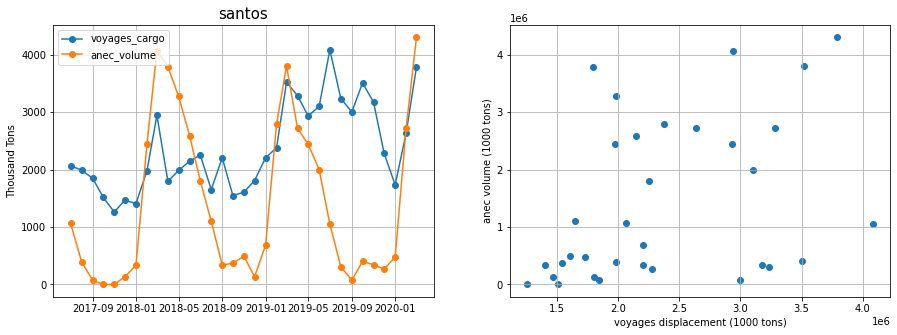

In [38]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

# time series comparison
ax[0].plot(merge_tmp.index, merge_tmp["est_cargo"] / 1e3, '-o', label="voyages_cargo")
ax[0].plot(merge_tmp.index, merge_tmp["volume"] / 1e3, '-o', label="anec_volume")
ax[0].set_title(uport, fontsize=15)
ax[0].grid(True)
ax[0].legend(loc="upper left")
ax[0].set_ylabel("Thousand Tons")

# scatter plot comparison
ax[1].scatter(merge_tmp["est_cargo"].values, merge_tmp["volume"].values)
ax[1].grid(True)
ax[1].set_ylabel("anec volume (1000 tons)")
ax[1].set_xlabel("voyages displacement (1000 tons)");

#### There is some correlation present, but not enough to draw a meaningful relationship. More than 80% of Brazil's soybean exports go to China, filtering for voyages ending in China should tighten up the signal

# Filter voyages ending in China

In [39]:
china_coast_fc = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {"name": "china_coast"},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [[120.498046875, 41.77131167976407],[117.42187500000001, 39.842286020743394],[116.3671875, 37.579412513438385],[118.38867187500001, 35.10193405724606],[118.38867187500001, 31.952162238024975],[117.158203125, 29.53522956294847],[113.90625, 26.980828590472107],[110.91796875, 25.403584973186703],[107.314453125, 23.725011735951796],[106.61132812499999, 23.079731762449878],[108.06152343749999, 21.49396356306447],[109.423828125, 20.838277806058933],[111.796875, 20.715015145512087],[114.697265625, 21.3303150734318],[117.50976562499999, 22.59372606392931],[119.17968749999999, 24.407137917727667],[121.5087890625, 27.176469131898898],[122.6953125, 29.99300228455108],[123.26660156249999, 31.466153715024294],[121.904296875, 33.90689555128866],[121.06933593749999, 35.639441068973944],[123.31054687499999, 36.70365959719456],[124.1455078125, 38.09998264736481],[124.23339843749999, 40.07807142745009],[122.607421875, 41.244772343082076],[120.498046875, 41.77131167976407]
          ]]
      }
    }
  ]
}

# make a dict of shapely shapes
china_coast_polys = {feat["properties"]["name"]: shapely.geometry.Polygon(feat["geometry"]["coordinates"][0])
                     for feat in china_coast_fc["features"]}

In [41]:
# identify voyages that ended in China and drop all others
vdf["china_dest"] = vdf.apply(lambda x: get_berth_from_point(x.destination, china_coast_polys), axis=1)

print(vdf.shape)
vdf = vdf[~vdf["china_dest"].isna()]
print(vdf.shape)

(5084, 19)
(1563, 19)


In [42]:
# re-examine Santos port
uport = "santos"

In [44]:
# isolate the export data for this port
apdf_tmp = apdf[apdf["port"] == uport].copy()
apdf_tmp= apdf_tmp.set_index("date")

# isolate the voyage data for this port and group by month
vdf_tmp = vdf[vdf["port"] == uport].copy().groupby("year_month").sum()[["est_cargo"]].reset_index()
vdf_tmp["date"] = vdf_tmp["year_month"].apply(str_to_dt)
vdf_tmp = vdf_tmp.sort_values(by="date").drop("year_month", axis=1).set_index("date")

# merge the two
merge_tmp = vdf_tmp.merge(apdf_tmp, how='outer', left_index=True, right_index=True).dropna()

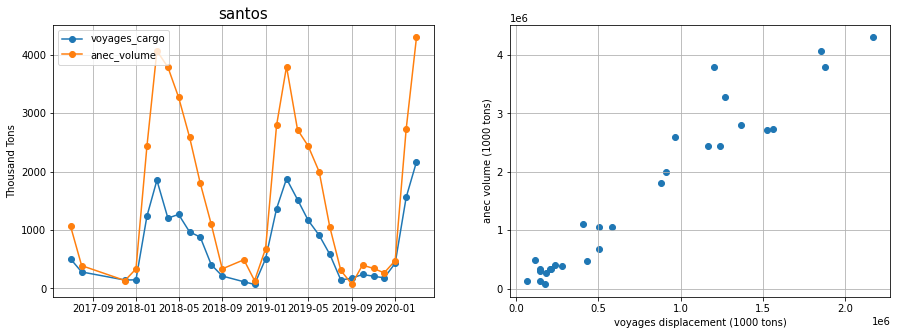

In [45]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

# time series comparison
ax[0].plot(merge_tmp.index, merge_tmp["est_cargo"] / 1e3, '-o', label="voyages_cargo")
ax[0].plot(merge_tmp.index, merge_tmp["volume"] / 1e3, '-o', label="anec_volume")
ax[0].set_title(uport, fontsize=15)
ax[0].grid(True)
ax[0].legend(loc="upper left")
ax[0].set_ylabel("Thousand Tons")

# scatter plot comparison
ax[1].scatter(merge_tmp["est_cargo"].values, merge_tmp["volume"].values)
ax[1].grid(True)
ax[1].set_ylabel("anec volume (1000 tons)")
ax[1].set_xlabel("voyages displacement (1000 tons)");

In [12]:
p1 = vector.table("ports")
p2 = p1.view()

intersections = p1.inner_join(p2, 
                              p1.port_geom.intersects(p2.port_geom) & 
                              (p1.port_name != p2.port_name))
intersections = intersections[p1.port_name,
                              p1.port_geom,
                              p2.port_name.name("intersects_port_name"),
                              p2.port_geom.name("intersects_port_geom")]
df = intersections.execute()
df

/home/joe/code/tutorials/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,port_name,port_geom,intersects_port_name,intersects_port_geom
0,NEWPORT NEWS,"POLYGON ((-76.41667 36.95500, -76.41000 36.965...",NORFOLK,"POLYGON ((-76.23216499999999 36.7202816666667,..."
1,HONG KONG,"POLYGON ((114.20500 21.85833, 114.45978 21.798...",SHEKOU,"POLYGON ((113.9046166667 22.3924333333, 113.90..."
2,PUERTO INGENIERO WHITE,"POLYGON ((-62.26167 -38.79167, -62.26338 -38.7...",BAHIA BLANCA,"POLYGON ((-62.2616666667 -38.7916666667, -62.2..."
3,NAPOLI,"POLYGON ((14.29685 40.81233, 14.29853 40.81426...",BAGNOLI,"POLYGON ((14.2034133333333 40.794965, 14.20357..."
4,GUANGZHOU,"POLYGON ((113.47833 23.06167, 113.47992 23.064...",HUANGPU,"POLYGON ((113.4783333333 23.0616666667, 113.47..."
5,VITORIA,"POLYGON ((-40.29677 -20.32192, -40.29983 -20.3...",TUBARAO,"POLYGON ((-40.14112 -20.42816, -40.13512 -20.3..."
6,PUERTO CRISTOBAL,"POLYGON ((-79.84035 9.37656, -79.87063 9.42502...",PUERTO COLON,"POLYGON ((-79.8403466667 9.37656, -79.87063000..."
7,SHEKOU,"POLYGON ((113.90462 22.39243, 113.90728 22.393...",HONG KONG,"POLYGON ((114.205 21.8583333333, 114.459776666..."
8,ASH SHARIQAH,"POLYGON ((55.39833 25.50500, 55.40224 25.51984...",SHARJAH OFFSHORE TERMINAL,"POLYGON ((55.3983333333 25.505, 55.40224 25.51..."
9,BAGNOLI,"POLYGON ((14.20341 40.79496, 14.20357 40.79501...",NAPOLI,"POLYGON ((14.2968516667 40.812335, 14.29853 40..."


In [27]:
routes = vector.table("voyages_routes")
expr = routes.group_by(routes.uid).order_by([routes.mmsi, ibis.desc(routes.timestamp)]).mutate(
    interval=routes.timestamp.cast("int64") - routes.timestamp.lag().cast("int64"))
expr.limit(100).execute()

/home/joe/code/tutorials/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: Unable to format expression type `<class 'ibis.expr.datatypes.Int64'>` from int64

#### The estimated volume magnitude is off, signaling some improvements needed in cargo calculation, but the correlation is much tighter